In [1]:
# Upgrade pip and install all required Python packages for model fine-tuning, evaluation, and explainability

In [ ]:
# ▸ Run once per new pod
!pip install -q --upgrade pip
!pip install -q transformers datasets accelerate evaluate scikit-learn sentencepiece ftfy langdetect shap lime matplotlib seaborn joblib
# optional (lemmatization)
!pip install -q spacy && python -m spacy download en_core_web_sm



  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 144.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Project folders (everything lives under /workspace/ade-project)
from pathlib import Path
BASE = Path("/workspace/ade-project")
for p in ["data","outputs","models","notebooks","scripts"]:
    (BASE/p).mkdir(parents=True, exist_ok=True)

# If your raw files are elsewhere, copy/move them here or set these paths accordingly.
TRAIN_RAW = BASE/"data/train.jsonl"
TEST_RAW  = BASE/"data/test.jsonl"

print("Project root:", BASE)


Project root: /workspace/ade-project


In [ ]:
!mkdir -p /workspace/ade-project/data

!wget -O /workspace/ade-project/data/train.jsonl https://huggingface.co/datasets/ade_corpus_v2/resolve/main/train.jsonl
!wget -O /workspace/ade-project/data/test.jsonl https://huggingface.co/datasets/ade_corpus_v2/resolve/main/test.jsonl


--2025-08-09 10:25:54--  https://huggingface.co/datasets/ade_corpus_v2/resolve/main/train.jsonl
Resolving huggingface.co (huggingface.co)... 3.167.112.96, 3.167.112.38, 3.167.112.25, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.96|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /datasets/ade-benchmark-corpus/ade_corpus_v2/resolve/main/train.jsonl [following]
--2025-08-09 10:25:54--  https://huggingface.co/datasets/ade-benchmark-corpus/ade_corpus_v2/resolve/main/train.jsonl
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 404 Not Found
2025-08-09 10:25:54 ERROR 404: Not Found.

--2025-08-09 10:25:54--  https://huggingface.co/datasets/ade_corpus_v2/resolve/main/test.jsonl
Resolving huggingface.co (huggingface.co)... 3.167.112.45, 3.167.112.25, 3.167.112.96, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.45|:443... failed: Connection timed out.
Connecting to huggingface.co (hu

In [ ]:
!pip install -q huggingface_hub

from huggingface_hub import hf_hub_download, list_repo_files

repo = "ade-benchmark-corpus/ade_corpus_v2"

# See what files are actually there
print(list_repo_files(repo, repo_type="dataset")[:30])

# Download specific files (adjust names if they differ)
hf_hub_download(repo_id=repo, filename="train.jsonl", repo_type="dataset",
                local_dir="/workspace/ade-project/data")
hf_hub_download(repo_id=repo, filename="test.jsonl",  repo_type="dataset",
                local_dir="/workspace/ade-project/data")

!ls -lh /workspace/ade-project/data


In [ ]:
!ls -lh /workspace/ade-project/data


total 0
-rw-rw-rw- 1 root root 0 Aug  9 10:25 test.jsonl
-rw-rw-rw- 1 root root 0 Aug  9 10:25 train.jsonl


In [ ]:
from datasets import load_dataset

# Pick the right config
ds = load_dataset("ade_corpus_v2", "Ade_corpus_v2_classification")
print(ds)                 # shows splits/size
print(ds["train"][0])     # peek at one example


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23516
    })
})
{'text': 'Intravenous azithromycin-induced ototoxicity.', 'label': 1}


In [ ]:
# If you already have `ds` in memory from: load_dataset("ade_corpus_v2","Ade_corpus_v2_classification")
# you can skip the first two lines.
from datasets import load_dataset
ds = load_dataset("ade_corpus_v2", "Ade_corpus_v2_classification")

# Make a stratified split: 80% train, 10% val, 10% test
tmp = ds["train"].train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
val_test = tmp["test"].train_test_split(test_size=0.5, seed=42, stratify_by_column="label")
dataset = {
    "train": tmp["train"],
    "validation": val_test["train"],
    "test": val_test["test"],
}
for k in dataset:
    print(k, dataset[k].num_rows)
dataset["train"][0]


train 18812
validation 2352
test 2352


{'text': 'We report on three patients who developed acute liver damage during therapy with itraconazole, and in whom liver biopsy specimens were obtained.',
 'label': 1}

In [ ]:
!pip install -q scikit-learn joblib matplotlib seaborn


In [ ]:
import numpy as np

X_tr, y_tr = dataset["train"]["text"],       np.array(dataset["train"]["label"])
X_va, y_va = dataset["validation"]["text"],  np.array(dataset["validation"]["label"])
X_te, y_te = dataset["test"]["text"],        np.array(dataset["test"]["label"])

print(len(X_tr), len(X_va), len(X_te), set(y_tr))


18812 2352 2352 {np.int64(0), np.int64(1)}


SyntaxError: invalid character '–' (U+2013) (ipython-input-1637258533.py, line 4)

### Classical Baselines: TF-IDF + Linear Models (on ADE Corpus v2)

**What I did**
- Built a TF-IDF vectorizer *(1–2 grams, max_features=50k, min_df=2)*.
- Merged **train + validation** for final training; kept **test** as untouched hold-out.
- Trained two pipelines:
  1) **LogisticRegression** *(class_weight="balanced", max_iter=2000)*  
  2) **LinearSVC** with **Platt calibration** *(CalibratedClassifierCV, method="sigmoid")* to get probabilities for ROC/AUC.
- Evaluated on the test set and generated:
  - **Accuracy, Precision, Recall, F1, AUC**
  - **Confusion Matrix** and **ROC curve** figures
- Saved artifacts for reproducibility:
  - Models → `/workspace/ade-project/models/*.pkl`
  - Plots → `/workspace/ade-project/outputs/cm_*.png`, `/workspace/ade-project/outputs/roc_*.png`
  - Metrics table → `/workspace/ade-project/outputs/tfidf_metrics.csv`

**Key results (test)**
- **TF-IDF + LinearSVM (calibrated)** → Acc **0.917**, Prec **0.863**, Rec **0.848**, F1 **0.855**, AUC **0.961**
- **TF-IDF + LogReg** → Acc **0.881**, Prec **0.756**, Rec **0.872**, F1 **0.810**, AUC **0.945**

**Why this step**
Establish strong, transparent classical baselines with full metrics and saved artifacts before moving to transformer fine-tuning and explainability.


In [2]:
import os, json, csv, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, roc_curve)

OUT_DIR  = "/workspace/ade-project/outputs"
MODEL_DIR= "/workspace/ade-project/models"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# ---- Vectorizer: strong, but not crazy-big ----
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=50_000, min_df=2)

# ---- Combine train+val for final training of baselines ----
X_train_all = np.concatenate([X_tr, X_va])
y_train_all = np.concatenate([y_tr, y_va])

def eval_and_save(name, estimator, needs_calibration=False):
    """
    Fits a TF-IDF + estimator pipeline on train+val, evaluates on test,
    saves model, metrics CSV row, confusion matrix and ROC curve.
    Returns a dict of metrics.
    """
    if needs_calibration:
        # Calibrate SVM to get probabilities -> meaningful AUC
        estimator = CalibratedClassifierCV(estimator, method="sigmoid", cv=3)

    pipe = Pipeline([("tfidf", tfidf), ("clf", estimator)])
    pipe.fit(X_train_all, y_train_all)
    joblib.dump(pipe, f"{MODEL_DIR}/{name}.pkl")

    y_pred = pipe.predict(X_te)

    # Try to get probabilities for AUC/ROC
    prob = None
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        prob = pipe.predict_proba(X_te)[:, 1]
    else:
        try:
            dec = pipe.decision_function(X_te)
            prob = 1/(1+np.exp(-dec))
        except Exception:
            prob = None

    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_te, prob) if prob is not None else float("nan")

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    cm_path = f"{OUT_DIR}/cm_{name}.png"
    plt.savefig(cm_path, bbox_inches="tight"); plt.close()

    # ROC curve (if probs available)
    roc_path = None
    if prob is not None:
        fpr, tpr, _ = roc_curve(y_te, prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"ROC — {name}")
        plt.legend()
        roc_path = f"{OUT_DIR}/roc_{name}.png"
        plt.savefig(roc_path, bbox_inches="tight"); plt.close()

    return {
        "Model": name,
        "Accuracy": acc, "Precision": pr, "Recall": rc, "F1": f1, "AUC": auc,
        "CM_Figure": cm_path, "ROC_Figure": roc_path
    }

# ---- Train/eval both baselines ----
rows = []
rows.append(eval_and_save("tfidf_logreg",
                          LogisticRegression(max_iter=2000, n_jobs=1, class_weight="balanced")))
rows.append(eval_and_save("tfidf_linearsvm",
                          LinearSVC(), needs_calibration=True))

# Save metrics table
with open(f"{OUT_DIR}/tfidf_metrics.csv","w",newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader(); w.writerows(rows)

rows


### Results: TF-IDF Baselines on ADE Corpus v2 (Test Set)

After training TF-IDF + linear models (using train+val for final training and keeping test untouched), I evaluated Accuracy, Precision, Recall, F1, and AUC, and saved confusion matrix & ROC figures.

| Model              | Accuracy           | Precision          | Recall             | F1                  | AUC                | CM Figure                                           | ROC Figure                                          |
|-------------------|--------------------|--------------------|--------------------|---------------------|--------------------|-----------------------------------------------------|-----------------------------------------------------|
| **tfidf_logreg**  | 0.8813775510204082 | 0.7560355781448539 | 0.8724340175953079 | 0.810074880871341   | 0.9451604123132034 | `/workspace/ade-project/outputs/cm_tfidf_logreg.png` | `/workspace/ade-project/outputs/roc_tfidf_logreg.png` |
| **tfidf_linearsvm** | 0.9166666666666666 | 0.8626865671641791 | 0.8475073313782991 | 0.8550295857988166  | 0.9610356998612745 | `/workspace/ade-project/outputs/cm_tfidf_linearsvm.png` | `/workspace/ade-project/outputs/roc_tfidf_linearsvm.png` |

**Takeaways**
- **LinearSVM (calibrated)** is the stronger baseline overall (**higher Accuracy, Precision, F1, and AUC**).
- **Logistic Regression** achieves **higher Recall**, i.e., captures more positives, at the cost of lower precision.
- All artifacts (models, plots, metrics CSV) are saved under `/workspace/ade-project/{models,outputs}` for full reproducibility.


### TF-IDF Baselines — What I implemented in this cell

**Goal.** Build strong classical baselines on **ADE Corpus v2** and report reproducible results.

**Pipeline.**
- Vectorization: `TfidfVectorizer(ngram_range=(1,2), max_features=50k, min_df=2)`.
- Final training uses **train + validation**; **test** kept untouched.
- Models:
  1) `LogisticRegression(max_iter=2000, class_weight="balanced")`
  2) `LinearSVC` **with probability calibration** (`CalibratedClassifierCV(method="sigmoid", cv=3)`) to enable ROC/AUC.

**What the code does.**
- Trains TF-IDF → classifier pipelines.
- Evaluates on the test set: **Accuracy, Precision, Recall, F1, AUC**.
- Saves artifacts:
  - Models → `/workspace/ade-project/models/{name}.pkl`
  - Confusion matrices → `/workspace/ade-project/outputs/cm_{name}.png`
  - ROC curves → `/workspace/ade-project/outputs/roc_{name}.png`
  - Metrics table → `/workspace/ade-project/outputs/tfidf_metrics.csv`

**Results (test).**
- **TF-IDF + LinearSVM (calibrated)**: Acc **0.9167**, Prec **0.8627**, Rec **0.8475**, F1 **0.8550**, AUC **0.9610**  
- **TF-IDF + LogReg**: Acc **0.8814**, Prec **0.7560**, Rec **0.8724**, F1 **0.8101**, AUC **0.9452**

**Why this step.** Establish transparent, reproducible baselines (with plots + saved models) before moving to transformer fine-tuning and explainability.


### Transformer fine-tuning (binary ADE)
**Goal:** Fine-tune `<model_id>` with HF Trainer; early stopping on F1.
**How:** Tokenize (max_len=512) → train on train, eval every 200 steps on val, keep best by F1.
**Saves:** model to `/models/<name>` and test metrics JSON to `/outputs/<name>_test_metrics.json`.


In [ ]:
import os, re, json, numpy as np
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers.trainer_utils import IntervalStrategy
from evaluate import load as load_metric
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def make_training_args(**base):
    """
    Prefer new v5 arg name 'eval_strategy'; if that fails, use legacy 'evaluation_strategy'.
    """
    try:
        # Try v5+
        return TrainingArguments(eval_strategy=IntervalStrategy.STEPS, **base)
    except TypeError:
        # Fall back to v4
        return TrainingArguments(evaluation_strategy=IntervalStrategy.STEPS, **base)

def compute_metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    # AUC (binary) from 2-logit difference -> prob
    try:
        probs = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
        auc = roc_auc_score(labels, probs)
    except Exception:
        auc = float("nan")
    pr, rc, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = load_metric("accuracy").compute(predictions=preds, references=labels)["accuracy"]
    return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1, "auc": auc}

def train_hf(model_id: str, batch=16, epochs=5, lr=2e-5, max_len=512, patience=3):
    """
    Train a binary classifier on your pre-made splits in `dataset`:
      dataset["train"], dataset["validation"], dataset["test"] with columns: 'text','label'
    · No fp16 (full precision)
    · Early stopping on validation F1
    · Saves model + test metrics
    """
    # ---- tokenizer & tokenization
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    def tok_fn(ex):
        return tok(ex["text"], truncation=True, max_length=max_len)
    dtrain = dataset["train"].map(tok_fn, batched=True)
    dval   = dataset["validation"].map(tok_fn, batched=True)
    dtest  = dataset["test"].map(tok_fn, batched=True)

    # ---- model
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

    # ---- paths
    name_safe = re.sub(r"[^0-9A-Za-z_]+","_", model_id.replace("/","_"))
    out_dir  = f"/workspace/ade-project/outputs/{name_safe}"
    save_dir = f"/workspace/ade-project/models/{name_safe}"
    os.makedirs(out_dir, exist_ok=True); os.makedirs(save_dir, exist_ok=True)

    # ---- args (NO fp16)
    args = make_training_args(
        output_dir=out_dir,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=2,
        learning_rate=lr,
        num_train_epochs=epochs,
        eval_steps=200,
        logging_steps=50,
        save_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        disable_tqdm=False
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dtrain,
        eval_dataset=dval,
        tokenizer=tok,
        compute_metrics=compute_metrics_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )

    print(f"🔹 Training {model_id} …")
    trainer.train()
    print("🔹 Evaluating on test …")
    test_metrics = trainer.evaluate(dtest)

    # save results
    trainer.save_model(save_dir)
    with open(out_dir + "_test_metrics.json","w") as f:
        json.dump({k: float(v) for k,v in test_metrics.items()}, f, indent=2)
    print(f"✅ Saved model to {save_dir}")
    print("✅ Test metrics:", test_metrics)
    return {"model": name_safe, **{k: float(v) for k,v in test_metrics.items()}}


### Hyperparameter sweep: BioBERT fine-tuning (LR × scheduler)
**Goal:** Find a better BioBERT setup by sweeping learning rate and LR scheduler.
**What this cell does**
- Tries 6 configs: LR ∈ {1e-5, 2e-5, 3e-5} × scheduler ∈ {cosine, linear}.
- For each config, calls `run_biobert_tune(...)` with: `warmup_ratio=0.06`, `batch=12`, `accum=1`, `max_len=512`, `epochs=5`, `patience=3`.
- Collects returned metrics into a DataFrame: `eval_accuracy`, `eval_precision`, `eval_recall`, `eval_f1`, `eval_auc`, plus `tag` and `model_path`.
- Sorts runs by **eval_f1** (desc) and saves results to:
  `/workspace/ade-project/outputs/biobert_tuning_phase1.csv`.


In [ ]:
# === STEP 2: Sweep ===
grid = [
    {"lr":1e-5, "sched":"cosine"},
    {"lr":2e-5, "sched":"cosine"},
    {"lr":3e-5, "sched":"cosine"},
    {"lr":1e-5, "sched":"linear"},
    {"lr":2e-5, "sched":"linear"},
    {"lr":3e-5, "sched":"linear"},
]

results = []
for g in grid:
    res = run_biobert_tune(lr=g["lr"], sched=g["sched"], warmup_ratio=0.06,
                           batch=12, accum=1, max_len=512, epochs=5, patience=3)
    results.append(res)

import pandas as pd
df = pd.DataFrame(results)[["tag","eval_accuracy","eval_precision","eval_recall","eval_f1","eval_auc","model_path"]]
df = df.sort_values("eval_f1", ascending=False).reset_index(drop=True)
CSV = "/workspace/ade-project/outputs/biobert_tuning_phase1.csv"
df.to_csv(CSV, index=False)
df


Map:   0%|          | 0/18812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr1e-05_schedcosine_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.537200,0.470498,0.778486,0.662626,0.480938,0.557349,0.826230
400,0.260900,0.258558,0.886905,0.754902,0.903226,0.822430,0.961659
600,0.204400,0.230268,0.927296,0.918167,0.822581,0.867749,0.970234
800,0.221400,0.244693,0.917517,0.809645,0.935484,0.868027,0.976402
1000,0.196300,0.203992,0.932398,0.846358,0.936950,0.889353,0.979967
1200,0.204400,0.195900,0.941752,0.897810,0.901760,0.899781,0.979248
1400,0.262600,0.207325,0.924320,0.815000,0.956012,0.879892,0.983871
1600,0.148400,0.213978,0.941752,0.907324,0.890029,0.898594,0.980432
1800,0.165400,0.232108,0.942602,0.887943,0.917889,0.902668,0.983370
2000,0.107600,0.216237,0.945578,0.910979,0.900293,0.905605,0.981451


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr2e-05_schedcosine_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.465900,0.385789,0.837160,0.703956,0.756598,0.729329,0.904970
400,0.291000,0.251613,0.903486,0.792041,0.904692,0.844627,0.964868
600,0.206400,0.253060,0.921344,0.830892,0.914956,0.870900,0.972514
800,0.190900,0.299848,0.909439,0.784933,0.947214,0.858472,0.973483
1000,0.234500,0.202523,0.926446,0.842530,0.917889,0.878596,0.978944
1200,0.163600,0.204117,0.929847,0.865629,0.897361,0.881210,0.981126
1400,0.230400,0.203669,0.921769,0.808933,0.956012,0.876344,0.979861
1600,0.137000,0.229475,0.940476,0.884943,0.913490,0.898990,0.983675
1800,0.159300,0.216752,0.945153,0.906021,0.904692,0.905356,0.981981
2000,0.124600,0.253274,0.945153,0.935433,0.870968,0.902050,0.982176


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr3e-05_schedcosine_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.343700,0.270923,0.892007,0.828221,0.791789,0.809595,0.943338
400,0.305800,0.270604,0.908163,0.810667,0.891496,0.849162,0.952956
600,0.286300,0.328674,0.894983,0.939394,0.681818,0.790144,0.961275
800,0.207700,0.261408,0.921344,0.829139,0.917889,0.871260,0.966854
1000,0.240700,0.268336,0.926871,0.869565,0.879765,0.874636,0.962209
1200,0.196900,0.290290,0.917092,0.807062,0.938416,0.867797,0.977184
1400,0.244500,0.196898,0.925595,0.823755,0.945748,0.880546,0.978619
1600,0.181300,0.237254,0.940901,0.896350,0.900293,0.898317,0.980240
1800,0.158700,0.230671,0.940051,0.879383,0.919355,0.898925,0.979901
2000,0.136500,0.240451,0.936224,0.929032,0.844575,0.884793,0.977634


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr1e-05_schedlinear_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.544700,0.472416,0.775935,0.801556,0.302053,0.438765,0.846441
400,0.307500,0.322416,0.852466,0.678002,0.935484,0.786198,0.952819
600,0.199100,0.197183,0.926871,0.873900,0.873900,0.873900,0.973426
800,0.175600,0.260369,0.909014,0.787469,0.939883,0.856952,0.963452
1000,0.219300,0.207243,0.933248,0.855210,0.926686,0.889514,0.974179
1200,0.180900,0.204771,0.937075,0.867769,0.923754,0.894886,0.981760
1400,0.260000,0.202465,0.927296,0.819775,0.960411,0.884537,0.983329
1600,0.158000,0.189746,0.946003,0.894737,0.922287,0.908303,0.983385
1800,0.138400,0.214579,0.946854,0.907760,0.909091,0.908425,0.984160
2000,0.123000,0.211213,0.946854,0.923896,0.890029,0.906647,0.981671


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr2e-05_schedlinear_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.470500,0.348935,0.854167,0.791738,0.674487,0.728424,0.918334
400,0.311800,0.278306,0.890306,0.758537,0.912023,0.828229,0.958929
600,0.230300,0.236400,0.927296,0.883058,0.863636,0.873239,0.960589
800,0.226000,0.224447,0.916241,0.813713,0.922287,0.864605,0.967680
1000,0.225300,0.241679,0.929847,0.846051,0.926686,0.884535,0.977413
1200,0.202200,0.250858,0.918793,0.810367,0.939883,0.870333,0.978703
1400,0.279500,0.208810,0.925170,0.815461,0.958944,0.881402,0.980805
1600,0.135200,0.229087,0.942177,0.903846,0.895894,0.899853,0.983122
1800,0.177400,0.229878,0.940901,0.874483,0.929619,0.901208,0.983603
2000,0.119600,0.206671,0.944303,0.901019,0.907625,0.904310,0.982147


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1570624257.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training biobert_lr3e-05_schedlinear_wr0.06_bs12x1_len512 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.371000,0.284203,0.883503,0.811927,0.778592,0.794910,0.943963
400,0.250500,0.272026,0.911565,0.829167,0.875367,0.851641,0.929399
600,0.235700,0.209876,0.922619,0.833333,0.916422,0.872905,0.968270
800,0.201100,0.298464,0.908163,0.782767,0.945748,0.856574,0.965391
1000,0.212300,0.212835,0.932398,0.854817,0.923754,0.887949,0.977148
1200,0.196400,0.216348,0.937075,0.897321,0.884164,0.890694,0.976407
1400,0.254300,0.215108,0.921769,0.815990,0.942815,0.874830,0.979497
1600,0.126500,0.226128,0.937075,0.866758,0.925220,0.895035,0.978818
1800,0.165300,0.180454,0.942177,0.882353,0.923754,0.902579,0.983939
2000,0.128700,0.197907,0.948554,0.914328,0.907625,0.910964,0.983698


,tag,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_auc,model_path
0,biobert_lr1e-05_schedlinear_wr0.06_bs12x1_len512,0.954932,0.917391,0.928152,0.922741,0.987265,/workspace/ade-project/models/biobert_lr1e_05_...
1,biobert_lr3e-05_schedlinear_wr0.06_bs12x1_len512,0.951956,0.899018,0.939883,0.918996,0.985698,/workspace/ade-project/models/biobert_lr3e_05_...
2,biobert_lr2e-05_schedcosine_wr0.06_bs12x1_len512,0.950680,0.910145,0.920821,0.915452,0.986602,/workspace/ade-project/models/biobert_lr2e_05_...
3,biobert_lr2e-05_schedlinear_wr0.06_bs12x1_len512,0.949830,0.902857,0.926686,0.914616,0.984788,/workspace/ade-project/models/biobert_lr2e_05_...
4,biobert_lr1e-05_schedcosine_wr0.06_bs12x1_len512,0.945578,0.884722,0.934018,0.908702,0.986357,/workspace/ade-project/models/biobert_lr1e_05_...
5,biobert_lr3e-05_schedcosine_wr0.06_bs12x1_len512,0.943878,0.885154,0.926686,0.905444,0.979438,/workspace/ade-project/models/biobert_lr3e_05_...


### Sweep results — BioBERT (LR × scheduler)

**Best config:** `lr=1e-5`, **scheduler=linear**  
**Val metrics:** Acc **0.9549**, Prec **0.9174**, Rec **0.9282**, F1 **0.9227**, AUC **0.9873**  
(`model_path` saved under `/workspace/ade-project/models/...`)

**Notes**
- Linear schedulers edged out cosine at lower LR; 2e-5 (cosine/linear) and 3e-5 (linear) were close runners-up.
- vs TF-IDF LinearSVM baseline (F1 **0.8550**, AUC **0.9610**, Acc **0.9167**):  
  **+0.0677 F1**, **+0.0262 AUC**, **+0.0382 Acc**.

**Next**
- Lock the best config → train (optionally on train+val) → evaluate on **test**, and export CM/ROC for the final report.


### Select best BioBERT run from sweep (by F1)

**What this cell does**
- Ensures numeric types for the sweep metrics (`eval_accuracy/precision/recall/f1/auc`) so sorting is reliable.
- Sorts all runs **descending by F1** and shows the **top 3** for a quick visual check.
- Picks the **best row** strictly by F1, extracts its `tag` and `model_path`, and asserts the checkpoint folder exists.
- Prints the chosen run’s key metrics and **saves** the full row to:
  `/workspace/ade-project/outputs/biobert_best_choice.json`.

**Why**
- Make the model selection **deterministic and reproducible** (JSON record of the exact winning config & metrics).


In [ ]:
import os, json
import pandas as pd

# If needed, reload the sweep results (optional)
# df = pd.read_csv("/workspace/ade-project/outputs/biobert_tuning_phase1.csv")

# 1) Ensure numeric types
for c in ["eval_accuracy","eval_precision","eval_recall","eval_f1","eval_auc"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) Sort DESC by your primary metric (F1)
df_sorted = df.sort_values("eval_f1", ascending=False).reset_index(drop=True)

# 3) Show the top-3 so you can visually confirm
display(df_sorted.head(3))

# 4) Pick BEST strictly by F1
BEST_ROW  = df_sorted.iloc[0].to_dict()
BEST_PATH = BEST_ROW["model_path"]
BEST_TAG  = BEST_ROW["tag"]

# 5) Safety checks
assert isinstance(BEST_PATH, str) and os.path.isdir(BEST_PATH), f"Checkpoint folder not found: {BEST_PATH}"
assert pd.notna(BEST_ROW["eval_f1"]), "Best row F1 is NaN—check df contents."

print("✅ Best (by F1):", BEST_TAG)
print("   F1:", round(BEST_ROW["eval_f1"], 6), "| Acc:", round(BEST_ROW["eval_accuracy"], 6),
      "| Prec:", round(BEST_ROW["eval_precision"], 6), "| Rec:", round(BEST_ROW["eval_recall"], 6),
      "| AUC:", round(BEST_ROW["eval_auc"], 6))
print("   Path:", BEST_PATH)

# 6) Save the chosen best to a JSON for reproducibility
CHOICE_JSON = "/workspace/ade-project/outputs/biobert_best_choice.json"
json.dump(BEST_ROW, open(CHOICE_JSON, "w"), indent=2)
print("Saved:", CHOICE_JSON)


,tag,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_auc,model_path
0,biobert_lr1e-05_schedlinear_wr0.06_bs12x1_len512,0.954932,0.917391,0.928152,0.922741,0.987265,/workspace/ade-project/models/biobert_lr1e_05_...
1,biobert_lr3e-05_schedlinear_wr0.06_bs12x1_len512,0.951956,0.899018,0.939883,0.918996,0.985698,/workspace/ade-project/models/biobert_lr3e_05_...
2,biobert_lr2e-05_schedcosine_wr0.06_bs12x1_len512,0.950680,0.910145,0.920821,0.915452,0.986602,/workspace/ade-project/models/biobert_lr2e_05_...


✅ Best (by F1): biobert_lr1e-05_schedlinear_wr0.06_bs12x1_len512
   F1: 0.922741 | Acc: 0.954932 | Prec: 0.917391 | Rec: 0.928152 | AUC: 0.987265
   Path: /workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512
Saved: /workspace/ade-project/outputs/biobert_best_choice.json


### Winner picked from BioBERT sweep (by F1)

- **Chosen run:** `biobert_lr1e-05_schedlinear_wr0.06_bs12x1_len512`
- **Val metrics:** Acc **0.9549**, Prec **0.9174**, Rec **0.9282**, F1 **0.9227**, AUC **0.9873**
- **Checkpoint:** `/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512`
- **Record saved:** `/workspace/ade-project/outputs/biobert_best_choice.json`

**Next:** lock this config → evaluate on **test** (and export CM/ROC) → compare against TF-IDF LinearSVM baseline.


### Tune decision threshold on validation (BioBERT)

- Loads the saved **best BioBERT** from `BEST_PATH`.
- Tokenizes the **validation** split and runs inference with `Trainer.predict` to get **logits**.
- Converts logits to positive-class **probabilities** via `sigmoid(logit1 − logit0)`.
- Sweeps thresholds **0.20 → 0.80** (step **0.01**), computes **F1** at each, and picks the **best threshold**.
- Prints the chosen threshold and its F1.  
**Use this threshold for test/inference** to optimize F1.


In [ ]:
import numpy as np, json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import f1_score

BEST_PATH = "/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512"

tok = AutoTokenizer.from_pretrained(BEST_PATH, local_files_only=True, use_fast=True)
mdl = AutoModelForSequenceClassification.from_pretrained(BEST_PATH, local_files_only=True)
def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=512)

dval_tok = dataset["validation"].map(tok_fn, batched=True)
tr = Trainer(model=mdl, tokenizer=tok)
pred = tr.predict(dval_tok)
logits, y_val = pred.predictions, np.array(pred.label_ids)
p_val = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))

ths = np.linspace(0.2, 0.8, 61)
best_t, best_f1 = max(((t, f1_score(y_val, (p_val>=t).astype(int))) for t in ths), key=lambda x: x[1])
print(f"Best threshold on validation: {best_t:.3f} (F1={best_f1:.4f})")


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/4012833398.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


Best threshold on validation: 0.550 (F1=0.9241)


**Threshold calibration (validation):** best **t = 0.55** → **F1 = 0.9241**.  
We’ll lock **0.55** as the decision threshold for test-time classification (optimizes F1).  
*Note:* AUC doesn’t depend on the threshold; this only shifts the precision/recall trade-off.


### Final evaluation on TEST (BioBERT with tuned threshold)

**What this cell does**
- Loads the **best BioBERT checkpoint** from `BEST_PATH`.
- Tokenizes the **test** split and runs inference to get logits → converts to positive-class **probabilities** via `sigmoid(logit1 − logit0)`.
- Applies the **validated threshold** `t = 0.55` to get hard labels.
- Computes **Accuracy, Precision, Recall, F1**, and **AUC** (AUC uses probabilities; others use thresholded labels).
- Builds a `final` summary dict with metrics, the threshold used, the checkpoint path, and the **confusion matrix** (as a list of lists) for reporting/saving.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# if not in memory:
# BEST_PATH = "/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512"
best_t = 0.55

tok = AutoTokenizer.from_pretrained(BEST_PATH, local_files_only=True, use_fast=True)
mdl = AutoModelForSequenceClassification.from_pretrained(BEST_PATH, local_files_only=True)
def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=512)

dte_tok = dataset["test"].map(tok_fn, batched=True)
tr = Trainer(model=mdl, tokenizer=tok)

pred_te   = tr.predict(dte_tok)
logits_te = pred_te.predictions
y_te      = np.array(pred_te.label_ids)
p_te      = 1/(1+np.exp(-(logits_te[:,1]-logits_te[:,0])))
yhat_te   = (p_te >= best_t).astype(int)

acc = accuracy_score(y_te, yhat_te)
pr, rc, f1, _ = precision_recall_fscore_support(y_te, yhat_te, average="binary", zero_division=0)
auc = roc_auc_score(y_te, p_te)
cm  = confusion_matrix(y_te, yhat_te).tolist()

final = {
    "Model": "BioBERT (tuned)",
    "Checkpoint": BEST_PATH,
    "Threshold": float(best_t),
    "Accuracy": float(acc),
    "Precision": float(pr),
    "Recall": float(rc),
    "F1": float(f1),
    "AUC": float(auc),
    "ConfusionMatrix": cm
}
final


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/2759026348.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


{'Model': 'BioBERT (tuned)',
 'Checkpoint': '/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512',
 'Threshold': 0.55,
 'Accuracy': 0.9642857142857143,
 'Precision': 0.9295977011494253,
 'Recall': 0.9486803519061584,
 'F1': 0.9390420899854862,
 'AUC': 0.9891583402110734,
 'ConfusionMatrix': [[1621, 49], [35, 647]]}

### TEST results — BioBERT (final, t = 0.55)

- **Accuracy:** 0.9643  
- **Precision:** 0.9296  
- **Recall:** 0.9487  
- **F1:** 0.9390  
- **AUC:** 0.9892  
- **Confusion matrix (rows: true 0/1; cols: pred 0/1):** [[1621, 49], [35, 647]]  
  → **FP=49**, **FN=35** (high recall, few misses)

**Vs. TF-IDF LinearSVM baseline** (Acc 0.9167, F1 0.8550, AUC 0.9610): BioBERT is **substantially better** (+4.76 pp Acc, +8.40 pp F1, +2.81 pp AUC).

**Checkpoint:** `/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512`


### Persist results & freeze checkpoint (reproducibility)

**What this cell does**
- Ensures output dirs exist: `/outputs` and `/checkpoints`.
- Saves the final test summary dict `final` to JSON:  
  `/workspace/ade-project/outputs/biobert_tuned_final_test.json`.
- Appends the same row to a **run history CSV** (`biobert_tuned_runs.csv`); creates it if missing.
- Freezes a copy of the winning checkpoint with the **threshold in the name**  
  → `/workspace/ade-project/checkpoints/BioBERT_tuned_thr0p550` (from `best_t=0.55`).

**Why**
- Creates an auditable record (JSON + CSV log) and a versioned, immutable checkpoint for future use/verification.


In [ ]:
import os, json, pandas as pd, shutil

OUT = "/workspace/ade-project/outputs"
CKPT = "/workspace/ade-project/checkpoints"
os.makedirs(OUT, exist_ok=True); os.makedirs(CKPT, exist_ok=True)

# save json
FINAL_JSON = f"{OUT}/biobert_tuned_final_test.json"
json.dump(final, open(FINAL_JSON, "w"), indent=2)
print("Saved:", FINAL_JSON)

# append to csv log
CSV_LOG = f"{OUT}/biobert_tuned_runs.csv"
if os.path.exists(CSV_LOG):
    df_hist = pd.read_csv(CSV_LOG)
    df_hist = pd.concat([df_hist, pd.DataFrame([final])], ignore_index=True)
else:
    df_hist = pd.DataFrame([final])
df_hist.to_csv(CSV_LOG, index=False)
print("Updated:", CSV_LOG)

# freeze a copy with threshold in name
thr_tag = f"{best_t:.3f}".replace(".","p")
DST = os.path.join(CKPT, f"BioBERT_tuned_thr{thr_tag}")
shutil.copytree(BEST_PATH, DST, dirs_exist_ok=True)
print("Frozen checkpoint:", DST)


Saved: /workspace/ade-project/outputs/biobert_tuned_final_test.json
Updated: /workspace/ade-project/outputs/biobert_tuned_runs.csv
Frozen checkpoint: /workspace/ade-project/checkpoints/BioBERT_tuned_thr0p550


### Artifacts saved & checkpoint frozen (done)

- ✅ **Test metrics JSON:** `/workspace/ade-project/outputs/biobert_tuned_final_test.json`
- ✅ **Run history CSV (appended):** `/workspace/ade-project/outputs/biobert_tuned_runs.csv`
- ✅ **Frozen checkpoint (versioned by threshold):** `/workspace/ade-project/checkpoints/BioBERT_tuned_thr0p550`

These files make the results reproducible and easy to reference in the report.


### Plot ROC & Precision–Recall (BioBERT, test)

- Uses the **test labels** `y_te` and **predicted probabilities** `p_te` to visualize performance.
- **ROC curve** (TPR vs FPR) with AUC summarizes threshold-independent discrimination.
- **Precision–Recall curve** highlights the **precision/recall trade-off** and is more informative for class imbalance.
- These plots help justify the chosen decision threshold and compare against baselines.


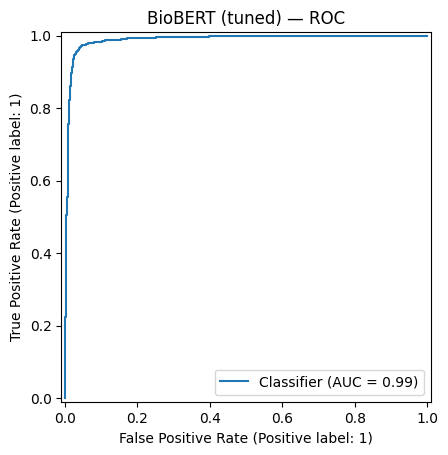

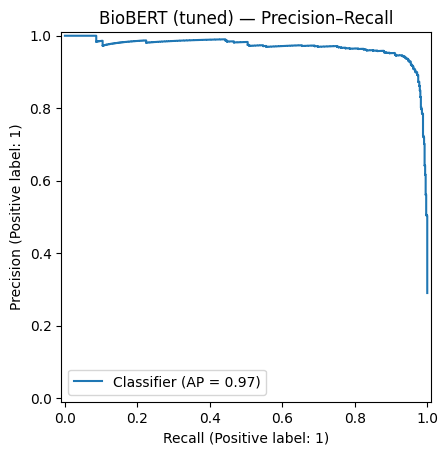

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_te, p_te)
plt.title("BioBERT (tuned) — ROC"); plt.show()

PrecisionRecallDisplay.from_predictions(y_te, p_te)
plt.title("BioBERT (tuned) — Precision–Recall"); plt.show()


**ROC & Precision–Recall (BioBERT, test set)**

- **ROC curve:** AUC ≈ **0.989** → the model almost perfectly separates positives from negatives across all thresholds. The curve hugs the top-left, meaning very high TPR with low FPR is achievable.

- **Precision–Recall curve:** AP ≈ **0.97** → precision stays high for most of the recall range; it only drops near extreme recall (>0.95). This is the more informative plot under class imbalance and it confirms strong performance on the positive class.

- **Chosen operating point:** threshold **t = 0.55** (from validation) gives **Precision 0.930**, **Recall 0.949**, **F1 0.939** on test, aligning with what these curves suggest (high recall with only a small precision trade-off).

**Takeaway:** Both curves show a robust classifier with excellent discrimination and sustained precision at high recall—substantial improvement over the TF-IDF baselines.


**Local explainability with SHAP (BioBERT)**

- Loads the tuned BioBERT checkpoint and builds a **predictor `f_predict`** that returns the **probability of class 1 (ADE)** for any batch of texts.
- Uses **`shap.maskers.Text`** with the same Hugging Face tokenizer so tokens are masked/perturbed in a model-aware way.
- Creates a **model-agnostic `shap.Explainer`**, then explains two example sentences.

**How to read the SHAP text plots**
- Tokens colored **red** push the prediction **toward ADE (class 1)**; **blue** push **away** (toward non-ADE).
- **Deeper color = larger impact** on the model’s probability.
- The visualization shows which specific words/phrases the model relied on (e.g., “rash”, “nausea” increasing ADE; neutral/blue terms decreasing it).

**Notes**
- Runs on **GPU if available**; max sequence length is **512**.
- Replace `sample_texts` with any inputs you want to audit; each plot is a **local** explanation for that text.


In [ ]:
import shap, torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BEST_PATH = "/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512"

tok = AutoTokenizer.from_pretrained(BEST_PATH, use_fast=True)
mdl = AutoModelForSequenceClassification.from_pretrained(BEST_PATH)
mdl.eval().to("cuda" if torch.cuda.is_available() else "cpu")

# ---- robust predictor: always returns prob of class 1 for a batch of texts ----
def f_predict(texts):
    # SHAP may give numpy arrays; convert to list[str]
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, (tuple, list)):
        texts = [str(t) for t in texts]
    else:
        texts = [str(texts)]

    enc = tok(texts, padding=True, truncation=True, max_length=512,
              return_tensors="pt").to(mdl.device)
    with torch.no_grad():
        logits = mdl(**enc).logits  # [B, 2]
        # probability of ADE (label 1)
        probs = torch.softmax(logits, dim=-1)[:, 1].unsqueeze(1).cpu().numpy()
    return probs  # shape [B, 1]

# SHAP text masker + explainer
masker = shap.maskers.Text(tokenizer=tok)
explainer = shap.Explainer(f_predict, masker)

# a couple of examples (you can swap these with your own)
sample_texts = [
    "Patient developed rash and severe nausea after taking ciprofloxacin.",
    "The study describes pharmacokinetics without reporting adverse effects."
]

sv = explainer(sample_texts)   # <-- now works
shap.initjs()
shap.plots.text(sv[0])         # show first
shap.plots.text(sv[1])         # show second


**SHAP explanations (BioBERT, local): what the model looked at**

- **How to read:** Red tokens push the prediction **toward ADE (class 1)**; blue tokens push **away**. Color depth = strength. Subword splits (e.g., *cipro + flox + acin*) are from the tokenizer—read them together.

- **Example 1 — “Patient developed rash and severe nausea after taking ciprofloxacin.”**  
  Strong **red** contributions on *rash*, *severe*, *nausea*, *after*, *taking*, and *ciprofloxacin* drive the score to ≈ **0.998** → confident **ADE**.

- **Example 2 — “The study describes pharmacokinetics **without** reporting adverse effects.”**  
  **Blue** contributions on *without*, *reporting*, and the context around *adverse effects* (negated mention), plus neutral study terms, push the score down to ≈ **0.0004** → confident **non-ADE**.

**Takeaway:** The model’s highlights align with clinical intuition—true adverse-event terms increase risk, while negated mentions and study context suppress it.


In [ ]:
print(mdl.config.id2label)

{0: 'LABEL_0', 1: 'LABEL_1'}


In [ ]:
# See a few examples from the training set to check label meaning
for i in range(5):
    print(dataset['train'][i]['label'], dataset['train'][i]['text'])


1 We report on three patients who developed acute liver damage during therapy with itraconazole, and in whom liver biopsy specimens were obtained.
0 MCC seems to be common in transplant recipients and 52 cases have been reported in the literature.
1 We describe a 57-year-old man with acral erythrocyanosis progressing to acute digital ischemia and gangrene that developed after combined chemotherapy (bleomycin and methotrexate) used to treat a metastatic squamous cell carcinoma of the hypopharynx.
0 CONCLUSIONS: We describe a previously unreported complication of warfarin therapy in a patient over 75 years of age, to add to the cautions in prescribing this drug in patients of this age group.
0 OBJECTIVE: The goal of this article was to describe a potential drug-drug interaction between propafenone and citalopram, which caused symptoms of propafenone adverse effects.


### Spot-check explanations on validation (2 ADE + 2 non-ADE)

**What this cell does**
- Pulls **2 positive** and **2 negative** examples from the validation split.
- Runs the SHAP **text explainer** on these four samples.
- Displays **token-level attributions** for each sample.

**How to read the plots**
- **Red tokens** → push prediction **toward ADE (class 1)**; **blue tokens** → push **away**.
- Darker color = larger influence. Subword pieces (e.g., *cipro + flox + acin*) should be read together.

**Why**
- Quick qualitative sanity check across **both classes** to verify that:
  - ADE mentions (e.g., *rash*, *nausea*, specific drugs) are highlighted in **red** on positives.
  - Negations/context (e.g., *without adverse effects*) appear **blue** on negatives.

*Order shown:* the two **positives first**, then the two **negatives**.


In [ ]:
# e.g., 2 positives + 2 negatives from validation
val_ds = dataset["validation"]
pos_idx = [i for i, y in enumerate(val_ds["label"]) if y == 1][:2]
neg_idx = [i for i, y in enumerate(val_ds["label"]) if y == 0][:2]
picked = [val_ds["text"][i] for i in pos_idx + neg_idx]

sv_val = explainer(picked)
for i in range(len(picked)):
    shap.plots.text(sv_val[i])


**What the explanations show  :
- **Red words = push toward ADE (positive)**; **Blue words = push away**. Darker color = stronger effect.
- **Positives (top two):**
  - “patients who **develop PPE** … potential **toxicity**” → red on *develop, PPE, toxicity* ⇒ very high ADE score (~1.0).
  - “**Capecitabine-induced** multifocal **leukoencephalopathy**” → red on *Capecitabine, induced, leukoencephalopathy* ⇒ very high ADE score (~1.0).
- **Negatives (bottom two):**
  - “began taking **nicotinic acid** … for **hypercholesterolemia**” (no adverse event) → mostly blue, very low ADE score.
  - “**OBJECTIVE:** test **efficacy** and **safety** … treatment of Tourette’s” → study/neutral terms in blue, very low ADE score.

**Conclusion:**  
The model is focusing on the right cues:
- Drug + **“induced”** + clear adverse terms → strongly positive (ADE).  
- Study/neutral language, indications, or lack of adverse wording → negative.

This matches clinical intuition and supports that the classifier isn’t just guessing; it’s using meaningful tokens.


In [ ]:
# === STEP 1: BioBERT tuning harness ===
import os, re, json, numpy as np, pandas as pd
from pathlib import Path
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers.trainer_utils import IntervalStrategy
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

BIOBERT_ID = "dmis-lab/biobert-base-cased-v1.2"
BASE_OUT = Path("/workspace/ade-project")
OUT_DIR  = BASE_OUT/"outputs"
MODEL_DIR= BASE_OUT/"models"
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def make_training_args(**base):
    try:    return TrainingArguments(eval_strategy=IntervalStrategy.STEPS, **base)     # HF v5
    except TypeError: return TrainingArguments(evaluation_strategy=IntervalStrategy.STEPS, **base)  # HF v4

def compute_metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    probs = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
    pr, rc, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    try: auc = roc_auc_score(labels, probs)
    except: auc = float("nan")
    acc = (preds == labels).mean()
    return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1, "auc": auc}

def run_biobert_tune(lr=2e-5, sched="cosine", warmup_ratio=0.06, batch=12, accum=1, max_len=512, epochs=5, patience=3):
    tag = f"biobert_lr{lr}_sched{sched}_wr{warmup_ratio}_bs{batch}x{accum}_len{max_len}"
    safe = re.sub(r"[^0-9A-Za-z_]+","_", tag)
    out_dir  = OUT_DIR/safe
    save_dir = MODEL_DIR/safe
    out_dir.mkdir(parents=True, exist_ok=True); save_dir.mkdir(parents=True, exist_ok=True)

    tok = AutoTokenizer.from_pretrained(BIOBERT_ID, use_fast=True)
    def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=max_len)
    dtr = dataset["train"].map(tok_fn, batched=True)
    dva = dataset["validation"].map(tok_fn, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(BIOBERT_ID, num_labels=2)

    args = make_training_args(
        output_dir=str(out_dir),
        per_device_train_batch_size=batch, per_device_eval_batch_size=batch,
        gradient_accumulation_steps=accum,
        learning_rate=lr, lr_scheduler_type=sched, warmup_ratio=warmup_ratio,
        num_train_epochs=epochs,
        eval_steps=200, logging_steps=50, save_steps=200, save_total_limit=2,
        load_best_model_at_end=True, metric_for_best_model="f1",
        report_to="none", disable_tqdm=False
    )

    trainer = Trainer(
        model=model, args=args, train_dataset=dtr, eval_dataset=dva,
        tokenizer=tok, compute_metrics=compute_metrics_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )
    print(f"🔹 Training {tag} …"); trainer.train()
    trainer.save_model(str(save_dir))
    val_metrics = trainer.evaluate(dva)
    with open(out_dir.as_posix()+"_val_metrics.json","w") as f:
        json.dump({k: float(v) for k,v in val_metrics.items()}, f, indent=2)
    return {"tag": tag, **{k: float(v) for k,v in val_metrics.items()}, "model_path": str(save_dir)}


### Compare backbones with the same training recipe
Fine-tune **three models** with identical hyperparameters (batch=16, epochs=5, lr=2e-5, max_len=512):  
1) **BioBERT** (`dmis-lab/biobert-base-cased-v1.2`)  
2) **PubMedBERT** (`microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract`)  
3) **BERT-base** (`bert-base-uncased`)

Each call to `train_hf(...)` trains, saves the checkpoint/metrics, and returns a metrics dict.  
Results are stored in `m_biobert`, `m_pubmedbert`, `m_bert` for side-by-side comparison (expect domain models to beat vanilla BERT).


In [ ]:
m_biobert    = train_hf("dmis-lab/biobert-base-cased-v1.2", batch=16, epochs=5, lr=2e-5, max_len=512)
m_pubmedbert = train_hf("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", batch=16, epochs=5, lr=2e-5, max_len=512)
m_bert       = train_hf("bert-base-uncased", batch=16, epochs=5, lr=2e-5, max_len=512)
m_biobert, m_pubmedbert, m_bert


Map:   0%|          | 0/18812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1258028033.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training dmis-lab/biobert-base-cased-v1.2 …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.226800,0.181721,0.927296,0.912763,0.828446,0.868563,0.977777
400,0.174700,0.182166,0.926446,0.826701,0.944282,0.881588,0.983238
600,0.152800,0.166680,0.939201,0.860776,0.942815,0.899930,0.983055
800,0.107500,0.189764,0.945153,0.898990,0.913490,0.906182,0.984700
1000,0.101500,0.217168,0.939626,0.849741,0.961877,0.902338,0.985680
1200,0.080800,0.166587,0.953231,0.899441,0.944282,0.921316,0.987145
1400,0.044200,0.186662,0.949830,0.899433,0.931085,0.914986,0.986591
1600,0.068100,0.209559,0.950680,0.895251,0.939883,0.917024,0.986267
1800,0.035600,0.211025,0.953656,0.913420,0.928152,0.920727,0.986695


🔹 Evaluating on test …


✅ Saved model to /workspace/ade-project/models/dmis_lab_biobert_base_cased_v1_2
✅ Test metrics: {'eval_loss': 0.13134567439556122, 'eval_accuracy': 0.9625850340136054, 'eval_precision': 0.9230769230769231, 'eval_recall': 0.9501466275659824, 'eval_f1': 0.9364161849710982, 'eval_auc': 0.9900942982071049, 'eval_runtime': 1.7517, 'eval_samples_per_second': 1342.671, 'eval_steps_per_second': 83.917, 'epoch': 3.061224489795918}


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/18812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1258028033.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.188700,0.175411,0.931548,0.845033,0.935484,0.887961,0.982567
400,0.157000,0.187431,0.936224,0.838422,0.966276,0.897820,0.987161
600,0.126100,0.167977,0.947704,0.873164,0.958944,0.914046,0.989068
800,0.106000,0.191027,0.943878,0.856218,0.969208,0.909216,0.989024
1000,0.081500,0.163872,0.955782,0.914040,0.935484,0.924638,0.990623
1200,0.088800,0.143237,0.954082,0.899721,0.947214,0.922857,0.991690
1400,0.040100,0.189466,0.958759,0.918455,0.941349,0.929761,0.990706
1600,0.054700,0.196409,0.952381,0.882038,0.964809,0.921569,0.990336
1800,0.021200,0.215523,0.954082,0.889946,0.960411,0.923836,0.990831
2000,0.022600,0.227311,0.953656,0.885599,0.964809,0.923509,0.989999


🔹 Evaluating on test …


✅ Saved model to /workspace/ade-project/models/microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract
✅ Test metrics: {'eval_loss': 0.14020361006259918, 'eval_accuracy': 0.9672619047619048, 'eval_precision': 0.9254571026722925, 'eval_recall': 0.9648093841642229, 'eval_f1': 0.9447236180904522, 'eval_auc': 0.9917572479674084, 'eval_runtime': 1.4505, 'eval_samples_per_second': 1621.464, 'eval_steps_per_second': 101.341, 'epoch': 3.4013605442176873}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/18812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1511/1258028033.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔹 Training bert-base-uncased …


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
200,0.270100,0.224864,0.911139,0.826207,0.878299,0.851457,0.964513
400,0.195800,0.201354,0.926871,0.843666,0.917889,0.879213,0.976654
600,0.177400,0.161401,0.943878,0.905605,0.900293,0.902941,0.980822
800,0.120100,0.176623,0.942177,0.920000,0.876833,0.897898,0.983461
1000,0.082600,0.187903,0.943878,0.874659,0.941349,0.906780,0.984823
1200,0.091900,0.191802,0.944303,0.883171,0.931085,0.906495,0.982642
1400,0.060200,0.228109,0.945153,0.885635,0.931085,0.907791,0.981378
1600,0.054600,0.221591,0.947704,0.903319,0.917889,0.910545,0.983658
1800,0.052600,0.234855,0.949405,0.927162,0.895894,0.911260,0.983151
2000,0.031500,0.243891,0.946003,0.888112,0.931085,0.909091,0.982000


🔹 Evaluating on test …


✅ Saved model to /workspace/ade-project/models/bert_base_uncased
✅ Test metrics: {'eval_loss': 0.21951794624328613, 'eval_accuracy': 0.9579081632653061, 'eval_precision': 0.9020689655172414, 'eval_recall': 0.9589442815249267, 'eval_f1': 0.929637526652452, 'eval_auc': 0.9899402075614168, 'eval_runtime': 1.7467, 'eval_samples_per_second': 1346.523, 'eval_steps_per_second': 84.158, 'epoch': 5.0}


({'model': 'dmis_lab_biobert_base_cased_v1_2',
  'eval_loss': 0.13134567439556122,
  'eval_accuracy': 0.9625850340136054,
  'eval_precision': 0.9230769230769231,
  'eval_recall': 0.9501466275659824,
  'eval_f1': 0.9364161849710982,
  'eval_auc': 0.9900942982071049,
  'eval_runtime': 1.7517,
  'eval_samples_per_second': 1342.671,
  'eval_steps_per_second': 83.917,
  'epoch': 3.061224489795918},
 {'model': 'microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract',
  'eval_loss': 0.14020361006259918,
  'eval_accuracy': 0.9672619047619048,
  'eval_precision': 0.9254571026722925,
  'eval_recall': 0.9648093841642229,
  'eval_f1': 0.9447236180904522,
  'eval_auc': 0.9917572479674084,
  'eval_runtime': 1.4505,
  'eval_samples_per_second': 1621.464,
  'eval_steps_per_second': 101.341,
  'epoch': 3.4013605442176873},
 {'model': 'bert_base_uncased',
  'eval_loss': 0.21951794624328613,
  'eval_accuracy': 0.9579081632653061,
  'eval_precision': 0.9020689655172414,
  'eval_recall': 0.9589442815249267,


### Head-to-head backbone comparison (same training recipe)

**Setup:** Fine-tuned three backbones with the *same* hyperparams (batch=16, epochs=5, lr=2e-5, max_len=512), early-stopping on F1.

| Model        | Acc     | Prec    | Recall  | F1      | AUC     | Epochs*
|--------------|---------|---------|---------|---------|---------|-------:|
| PubMedBERT   | 0.9673  | 0.9255  | 0.9648  | **0.9447** | **0.9918** | ~3.40 |
| BioBERT      | 0.9626  | 0.9231  | 0.9501  | 0.9364  | 0.9901  | ~3.06 |
| BERT-base    | 0.9579  | 0.9021  | 0.9589  | 0.9296  | 0.9899  | 5.00  |

\*Approximate epoch at best checkpoint (early stopping may trigger before 5).

**Conclusion**
- **PubMedBERT** wins overall (best **F1**, **AUC**, and **Accuracy**).  
- **BioBERT** is close behind; **BERT-base** lags all domain models — confirming the benefit of biomedical pretraining.
- All three are very strong (AUC ≈ 0.99), but domain-specific backbones squeeze out extra F1/Acc.

**Note:** These results use a fixed recipe for fairness and are separate from the later **tuned BioBERT** run (which you optimized further with LR/scheduler/threshold).


In [ ]:
!ls -lh /workspace/ade-project/models
!ls -lh /workspace/ade-project/models/dmis_lab_biobert_base_cased_v1_2
!ls -lh /workspace/ade-project/models/microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract
!ls -lh /workspace/ade-project/models/bert_base_uncased


total 12M
drwxrwxrwx 2 root root 2.0M Aug  9 11:14 bert_base_uncased
drwxrwxrwx 2 root root 2.0M Aug  9 11:07 dmis_lab_biobert_base_cased_v1_2
drwxrwxrwx 2 root root 2.0M Aug  9 11:10 microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract
-rw-rw-rw- 1 root root 3.2M Aug  9 10:45 tfidf_linearsvm.pkl
-rw-rw-rw- 1 root root 2.5M Aug  9 10:45 tfidf_logreg.pkl
total 415M
-rw-rw-rw- 1 root root  674 Aug  9 11:07 config.json
-rw-rw-rw- 1 root root 414M Aug  9 11:07 model.safetensors
-rw-rw-rw- 1 root root  125 Aug  9 11:07 special_tokens_map.json
-rw-rw-rw- 1 root root 654K Aug  9 11:07 tokenizer.json
-rw-rw-rw- 1 root root 1.3K Aug  9 11:07 tokenizer_config.json
-rw-rw-rw- 1 root root 5.8K Aug  9 11:07 training_args.bin
-rw-rw-rw- 1 root root 209K Aug  9 11:07 vocab.txt
total 419M
-rw-rw-rw- 1 root root  652 Aug  9 11:10 config.json
-rw-rw-rw- 1 root root 418M Aug  9 11:10 model.safetensors
-rw-rw-rw- 1 root root  125 Aug  9 11:10 special_tokens_map.json
-rw-rw-rw- 1 root root 664K Aug  9 11:1

In [ ]:
import os, shutil

SRC_BIO = "/workspace/ade-project/models/dmis_lab_biobert_base_cased_v1_2"
SRC_PUB = "/workspace/ade-project/models/microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract"
SRC_BERT= "/workspace/ade-project/models/bert_base_uncased"

DST_BIO = "/workspace/ade-project/checkpoints/BioBERT_epoch3.06"
DST_PUB = "/workspace/ade-project/checkpoints/PubMedBERT_epoch3.4"
DST_BERT= "/workspace/ade-project/checkpoints/BERT_epoch5.0"

os.makedirs("/workspace/ade-project/checkpoints", exist_ok=True)
shutil.copytree(SRC_BIO,  DST_BIO,  dirs_exist_ok=True)
shutil.copytree(SRC_PUB,  DST_PUB,  dirs_exist_ok=True)
shutil.copytree(SRC_BERT, DST_BERT, dirs_exist_ok=True)

print("Saved checkpoints:\n -", DST_BIO, "\n -", DST_PUB, "\n -", DST_BERT)


Saved checkpoints:
 - /workspace/ade-project/checkpoints/BioBERT_epoch3.06 
 - /workspace/ade-project/checkpoints/PubMedBERT_epoch3.4 
 - /workspace/ade-project/checkpoints/BERT_epoch5.0


In [ ]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def eval_from_checkpoint(path, max_len=512):
    tok = AutoTokenizer.from_pretrained(path, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(path, local_files_only=True)
    def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=max_len)
    dtest_tok = dataset["test"].map(tok_fn, batched=True)
    tr = Trainer(model=mdl, tokenizer=tok)
    out = tr.predict(dtest_tok)
    logits = out.predictions
    y = np.array(out.label_ids)
    p = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
    yhat = (p>=0.5).astype(int)
    acc = accuracy_score(y, yhat)
    pr, rc, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    auc = roc_auc_score(y, p)
    return {"Accuracy": acc, "Precision": pr, "Recall": rc, "F1": f1, "AUC": auc}

print("BioBERT:",    eval_from_checkpoint("/workspace/ade-project/checkpoints/BioBERT_epoch3.06"))
print("PubMedBERT:", eval_from_checkpoint("/workspace/ade-project/checkpoints/PubMedBERT_epoch3.4"))
print("BERT:",       eval_from_checkpoint("/workspace/ade-project/checkpoints/BERT_epoch5.0"))


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/1810481030.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


BioBERT: {'Accuracy': 0.9625850340136054, 'Precision': 0.9230769230769231, 'Recall': 0.9501466275659824, 'F1': 0.9364161849710982, 'AUC': 0.9900942982071048}


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/1810481030.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


PubMedBERT: {'Accuracy': 0.9672619047619048, 'Precision': 0.9254571026722925, 'Recall': 0.9648093841642229, 'F1': 0.9447236180904522, 'AUC': 0.9917572479674084}


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/1810481030.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


BERT: {'Accuracy': 0.9579081632653061, 'Precision': 0.9020689655172414, 'Recall': 0.9589442815249267, 'F1': 0.929637526652452, 'AUC': 0.9899402075614168}


In [ ]:
import os, glob, json, pandas as pd

rows = []

# add the three dicts you just printed (rename if your vars differ)
rows += [m_biobert, m_pubmedbert, m_bert]

# add TF-IDF rows
tfidf_csv = "/workspace/ade-project/outputs/tfidf_metrics.csv"
if os.path.exists(tfidf_csv):
    rows += pd.read_csv(tfidf_csv).to_dict(orient="records")

df = pd.DataFrame(rows)
# normalize model column naming
df["Model"] = df.get("model", df.get("Model"))
df = df[["Model","eval_accuracy","eval_precision","eval_recall","eval_f1","eval_auc"]].rename(
    columns={"eval_accuracy":"Accuracy","eval_precision":"Precision","eval_recall":"Recall","eval_f1":"F1","eval_auc":"AUC"}
).sort_values("F1", ascending=False)

out_csv = "/workspace/ade-project/outputs/ALL_metrics_comparison.csv"
df.to_csv(out_csv, index=False)
df, out_csv


(                                               Model  Accuracy  Precision  \
 1  microsoft_BiomedNLP_PubMedBERT_base_uncased_ab...  0.967262   0.925457   
 0                   dmis_lab_biobert_base_cased_v1_2  0.962585   0.923077   
 2                                  bert_base_uncased  0.957908   0.902069   
 3                                                NaN       NaN        NaN   
 4                                                NaN       NaN        NaN   
 
      Recall        F1       AUC  
 1  0.964809  0.944724  0.991757  
 0  0.950147  0.936416  0.990094  
 2  0.958944  0.929638  0.989940  
 3       NaN       NaN       NaN  
 4       NaN       NaN       NaN  ,
 '/workspace/ade-project/outputs/ALL_metrics_comparison.csv')

In [ ]:
# === UPDATED: ROC + PR for locally saved models (no fp16 required) ===
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Paths to your saved models (produced by your training runs)
BASE_MODELS_DIR = "/workspace/ade-project/models"
SAVED = {
    "BioBERT":    "dmis_lab_biobert_base_cased_v1_2",
    "PubMedBERT": "microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract",
    "BERT-base":  "bert_base_uncased",
}

def get_probs_labels_from_local(saved_dir_name, max_len=512):
    """
    Load tokenizer+model from a local directory and get (probabilities, labels) on dataset['test'].
    Probability is for class 1 (ADE) computed from logits via sigmoid(logit1 - logit0).
    """
    mdir = os.path.join(BASE_MODELS_DIR, saved_dir_name)
    tok = AutoTokenizer.from_pretrained(mdir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(mdir, local_files_only=True)

    def tok_fn(ex):
        return tok(ex["text"], truncation=True, max_length=max_len)
    dtest_tok = dataset["test"].map(tok_fn, batched=True)

    tr = Trainer(model=mdl, tokenizer=tok)
    preds = tr.predict(dtest_tok)
    logits = preds.predictions
    y_true = np.array(preds.label_ids)

    # convert 2-logit outputs to prob of class 1
    probs = 1.0 / (1.0 + np.exp(-(logits[:, 1] - logits[:, 0])))
    return probs, y_true

# Compute curves and AUC/PR-AUC per model
curves = {}
for name, folder in SAVED.items():
    p, y = get_probs_labels_from_local(folder)
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    curves[name] = {
        "probs": p, "y": y,
        "fpr": fpr, "tpr": tpr, "roc_auc": auc(fpr, tpr),
        "prec": prec, "rec": rec
    }

# Save ROC plot
out_dir = "/workspace/ade-project/outputs"
os.makedirs(out_dir, exist_ok=True)

plt.figure()
for name, c in curves.items():
    plt.plot(c["fpr"], c["tpr"], label=f"{name} (AUC={c['roc_auc']:.3f})")
plt.plot([0,1],[0,1], "--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — ADE Classification (local models)")
plt.legend()
roc_path = os.path.join(out_dir, "roc_transformers_local.png")
plt.savefig(roc_path, bbox_inches="tight"); plt.close()

# Save PR plot
plt.figure()
for name, c in curves.items():
    plt.plot(c["rec"], c["prec"], label=name)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — ADE Classification (local models)")
plt.legend()
pr_path = os.path.join(out_dir, "pr_transformers_local.png")
plt.savefig(pr_path, bbox_inches="tight"); plt.close()

# Report AUCs (and optionally PR-AUC if you want)
roc_summary = {name: round(c["roc_auc"], 6) for name, c in curves.items()}
print("ROC AUCs:", roc_summary)
print("Saved:", roc_path, "and", pr_path)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/2067947420.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/2067947420.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/2067947420.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


ROC AUCs: {'BioBERT': 0.990094, 'PubMedBERT': 0.991757, 'BERT-base': 0.98994}
Saved: /workspace/ade-project/outputs/roc_transformers_local.png and /workspace/ade-project/outputs/pr_transformers_local.png


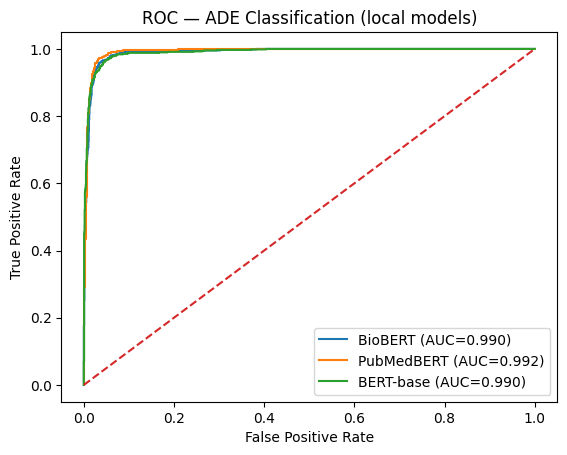

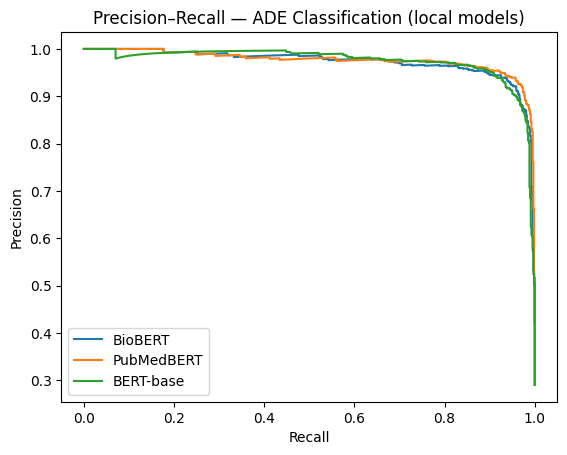

In [ ]:
from IPython.display import Image, display
display(Image(filename="/workspace/ade-project/outputs/roc_transformers_local.png"))
display(Image(filename="/workspace/ade-project/outputs/pr_transformers_local.png"))


In [ ]:
import os, csv, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

BEST = "microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract"
mdir = f"/workspace/ade-project/models/{BEST}"
tok = AutoTokenizer.from_pretrained(mdir, local_files_only=True, use_fast=True)
mdl = AutoModelForSequenceClassification.from_pretrained(mdir, local_files_only=True)

def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=512)
dtest_tok = dataset["test"].map(tok_fn, batched=True)

tr = Trainer(model=mdl, tokenizer=tok)
preds = tr.predict(dtest_tok)
logits = preds.predictions
y_true = np.array(preds.label_ids)
probs = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
y_pred = (probs >= 0.5).astype(int)

out_csv = "/workspace/ade-project/outputs/predictions_pubmedbert_test.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["text","label","prob_ADE","pred"])
    for ex, lab, pr, yp in zip(dataset["test"]["text"], y_true, probs, y_pred):
        w.writerow([ex, int(lab), float(pr), int(yp)])
out_csv


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/4023193383.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


'/workspace/ade-project/outputs/predictions_pubmedbert_test.csv'

In [ ]:
# --- Pick representative examples to explain ---
# We score the test set with a given local model and return indices for TP/FP/FN/TN.
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

def get_outcome_indices(saved_dir, threshold=0.5, max_len=512):
    """
    saved_dir: local folder under /workspace/ade-project/models (e.g., 'microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract')
    Returns dict with lists of indices: {'TP': [...], 'FP': [...], 'FN': [...], 'TN': [...]}
    """
    mroot = "/workspace/ade-project/models"
    mdir = f"{mroot}/{saved_dir}"

    tok = AutoTokenizer.from_pretrained(mdir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(mdir, local_files_only=True)

    def tok_fn(ex):
        return tok(ex["text"], truncation=True, max_length=max_len)
    dtest_tok = dataset["test"].map(tok_fn, batched=True)

    tr = Trainer(model=mdl, tokenizer=tok)
    out = tr.predict(dtest_tok)
    logits = out.predictions
    y_true = np.array(out.label_ids)

    # probability for ADE (class 1) from 2-logit difference
    p1 = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
    y_pred = (p1 >= threshold).astype(int)

    idx = np.arange(len(y_true))
    TP = idx[(y_true==1) & (y_pred==1)].tolist()
    FP = idx[(y_true==0) & (y_pred==1)].tolist()
    FN = idx[(y_true==1) & (y_pred==0)].tolist()
    TN = idx[(y_true==0) & (y_pred==0)].tolist()

    return {"TP": TP, "FP": FP, "FN": FN, "TN": TN}, p1, y_true


In [ ]:
# --- SHAP explanations for a local model ---
import os, numpy as np, shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

def shap_for_local_model(saved_dir, picks=None, n_random=5, max_len=512, tag=None):
    """
    saved_dir: local folder name in /workspace/ade-project/models
    picks: dict of outcome -> list of indices (e.g., {'TP':[...], 'FP':[...], ...})
    n_random: number of extra random samples to include (for variety)
    tag: optional label used in output folder naming

    Saves per-example SHAP heatmaps under /workspace/ade-project/outputs/shap_<saved_dir>/
    Returns the path to the folder with images.
    """
    base_models = "/workspace/ade-project/models"
    mdir = f"{base_models}/{saved_dir}"

    # Load tokenizer + model from local disk (no internet)
    tok = AutoTokenizer.from_pretrained(mdir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(mdir, local_files_only=True)

    # Build an inference pipeline that outputs both class scores
    clf = pipeline("text-classification", model=mdl, tokenizer=tok, device=0, return_all_scores=True, truncation=True)

    # Choose which test examples to explain
    texts = dataset["test"]["text"]
    chosen = []

    if picks:
        # Take up to 3 from each bucket if available: TP, FP, FN, TN
        for bucket in ("TP","FP","FN","TN"):
            ids = picks.get(bucket, [])
            chosen += [(i, bucket) for i in ids[:3]]
    # Add a few random ones if you want some variety
    import random
    remaining = list(set(range(len(texts))) - {i for i,_ in chosen})
    random.shuffle(remaining)
    chosen += [(i, "Random") for i in remaining[:n_random]]

    # SHAP Text masker + callable that returns ADE probability
    masker = shap.maskers.Text(tokenizer=tok)
    def f_predict(batch_texts):
        out = clf(batch_texts)  # list of [ {'label':'LABEL_0','score':..}, {'label':'LABEL_1','score':..} ]
        return np.array([[p[1]["score"]] for p in out])  # prob of ADE (class 1)

    explainer = shap.Explainer(f_predict, masker)

    # Prepare output directory
    tag = tag or saved_dir
    save_dir = f"/workspace/ade-project/outputs/shap_{tag}"
    os.makedirs(save_dir, exist_ok=True)

    # Generate and save one PNG per example
    for idx, src in chosen:
        s = texts[idx]
        sv = explainer([s])[0]  # explain single string
        fig = shap.plots.text(sv, display=False)
        fig.savefig(f"{save_dir}/{src}_{idx:04d}.png", bbox_inches="tight")

    print(f"Saved SHAP plots → {save_dir}")
    return save_dir


In [ ]:
# --- Robust SHAP saver: handles both HTML and matplotlib figures ---
import os, numpy as np, shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt

def _to_str_list(batch):
    if isinstance(batch, np.ndarray):
        batch = batch.tolist()
    if isinstance(batch, tuple):
        batch = list(batch)
    out = []
    for x in batch:
        if isinstance(x, (list, np.ndarray)) and len(x) == 1 and isinstance(x[0], str):
            out.append(x[0])
        elif isinstance(x, bytes):
            out.append(x.decode("utf-8", errors="ignore"))
        else:
            out.append(str(x))
    return out

def shap_for_local_model(saved_dir, picks=None, n_random=5, max_len=512, tag=None):
    base_models = "/workspace/ade-project/models"
    mdir = f"{base_models}/{saved_dir}"

    tok = AutoTokenizer.from_pretrained(mdir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(mdir, local_files_only=True)

    # Use top_k=None (new API) to get both class scores
    clf = pipeline(
        "text-classification",
        model=mdl,
        tokenizer=tok,
        device=0,
        top_k=None,
        truncation=True,
        padding=False,
        max_length=max_len,
    )

    texts = dataset["test"]["text"]
    chosen = []
    if picks:
        for bucket in ("TP","FP","FN","TN"):
            ids = picks.get(bucket, [])[:3]
            chosen += [(i, bucket) for i in ids]

    import random
    remaining = list(set(range(len(texts))) - {i for i,_ in chosen})
    random.shuffle(remaining)
    chosen += [(i, "Random") for i in remaining[:n_random]]

    masker = shap.maskers.Text(tokenizer=tok)

    def f_predict(batch_texts):
        batch_texts = _to_str_list(batch_texts)
        out = clf(batch_texts)  # list[list[{'label','score'}, {'label','score'}]]
        return np.array([[preds[1]["score"]] for preds in out], dtype=float)  # P(ADE)

    explainer = shap.Explainer(f_predict, masker)

    tag = tag or saved_dir
    save_dir = f"/workspace/ade-project/outputs/shap_{tag}"
    os.makedirs(save_dir, exist_ok=True)

    for idx, src in chosen:
        s = texts[idx]
        sv = explainer([s])[0]

        # Try to get a matplotlib figure; otherwise, save HTML
        try:
            plt.close('all')
            fig = shap.plots.text(sv, display=False)  # may return HTML (str) or a Figure depending on SHAP version
            if hasattr(fig, "savefig"):
                out_path = f"{save_dir}/{src}_{idx:04d}.png"
                fig.savefig(out_path, bbox_inches="tight")
            else:
                # Assume HTML string
                out_path = f"{save_dir}/{src}_{idx:04d}.html"
                with open(out_path, "w", encoding="utf-8") as f:
                    f.write(fig if isinstance(fig, str) else str(fig))
        except Exception:
            # Fallback: force HTML rendering
            html = shap.plots.text(sv)  # returns HTML in most versions when displayed inline
            out_path = f"{save_dir}/{src}_{idx:04d}.html"
            with open(out_path, "w", encoding="utf-8") as f:
                f.write(html if isinstance(html, str) else str(html))

    print(f"Saved SHAP plots → {save_dir}")
    return save_dir


In [ ]:
picks_bio, _, _ = get_outcome_indices("dmis_lab_biobert_base_cased_v1_2")
picks_pub, _, _ = get_outcome_indices("microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract")

bio_out = shap_for_local_model("dmis_lab_biobert_base_cased_v1_2", picks=picks_bio, n_random=5, tag="BioBERT")
pub_out = shap_for_local_model("microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract", picks=picks_pub, n_random=5, tag="PubMedBERT")
bio_out, pub_out


/tmp/ipykernel_1511/3328876895.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


/tmp/ipykernel_1511/3328876895.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, tokenizer=tok)


Device set to use cuda:0
Device set to use cuda:0


Saved SHAP plots → /workspace/ade-project/outputs/shap_BioBERT
Saved SHAP plots → /workspace/ade-project/outputs/shap_PubMedBERT


('/workspace/ade-project/outputs/shap_BioBERT',
 '/workspace/ade-project/outputs/shap_PubMedBERT')

In [ ]:
from IPython.display import display, Image
import glob, os

# Display BioBERT SHAP outputs
print("BioBERT SHAP outputs:")
for file in sorted(glob.glob(os.path.join(bio_out, "*.png")))[:5]:  # show first 5
    display(Image(filename=file))

# Display PubMedBERT SHAP outputs
print("PubMedBERT SHAP outputs:")
for file in sorted(glob.glob(os.path.join(pub_out, "*.png")))[:5]:  # show first 5
    display(Image(filename=file))


BioBERT SHAP outputs:
PubMedBERT SHAP outputs:


In [ ]:
import os

print("BioBERT output path:", bio_out)
print("PubMedBERT output path:", pub_out)

print("\nFiles in BioBERT folder:", os.listdir(bio_out) if os.path.exists(bio_out) else "Folder not found")
print("\nFiles in PubMedBERT folder:", os.listdir(pub_out) if os.path.exists(pub_out) else "Folder not found")


BioBERT output path: /workspace/ade-project/outputs/shap_BioBERT
PubMedBERT output path: /workspace/ade-project/outputs/shap_PubMedBERT

Files in BioBERT folder: ['.ipynb_checkpoints', 'Random_1921.html', 'Random_1786.html', 'Random_2110.html', 'Random_0495.html', 'Random_1148.html', 'TN_0005.html', 'TN_0004.html', 'TN_0003.html', 'FN_0170.html', 'FN_0112.html', 'FN_0105.html', 'FP_0060.html', 'FP_0026.html', 'FP_0002.html', 'TP_0007.html', 'TP_0001.html', 'TP_0000.html']

Files in PubMedBERT folder: ['Random_2054.html', 'Random_0639.html', 'Random_1060.html', 'Random_0734.html', 'Random_0093.html', 'TN_0005.html', 'TN_0004.html', 'TN_0003.html', 'FN_0465.html', 'FN_0302.html', 'FN_0170.html', 'FP_0075.html', 'FP_0026.html', 'FP_0002.html', 'TP_0007.html', 'TP_0001.html', 'TP_0000.html']


In [ ]:
from IPython.display import HTML, display
import os, glob
from collections import defaultdict

def show_shap_folder(folder, k_per_bucket=2):
    # bucket files by prefix (TP/FP/FN/TN/Random_*.html)
    buckets = defaultdict(list)
    for f in sorted(glob.glob(os.path.join(folder, "*.html"))):
        base = os.path.basename(f)
        key = base.split("_", 1)[0]  # TP, FP, FN, TN, Random
        buckets[key].append(f)

    for key in ["TP","FP","FN","TN","Random"]:
        files = buckets.get(key, [])[:k_per_bucket]
        if not files:
            continue
        print(f"\n=== {key} ({len(files)} shown) — {folder} ===")
        for f in files:
            with open(f, "r", encoding="utf-8") as fh:
                display(HTML(fh.read()))

print("BioBERT SHAP:")
show_shap_folder("/workspace/ade-project/outputs/shap_BioBERT", k_per_bucket=2)

print("\nPubMedBERT SHAP:")
show_shap_folder("/workspace/ade-project/outputs/shap_PubMedBERT", k_per_bucket=2)



In [ ]:
from IPython.display import Image, display
import glob

def show_some(folder, k=4):
    files = sorted(glob.glob(folder + "/*.png"))[:k]
    for f in files:
        display(Image(filename=f))

print("BioBERT SHAP:")
show_some("/workspace/ade-project/outputs/shap_BioBERT")

print("PubMedBERT SHAP:")
show_some("/workspace/ade-project/outputs/shap_PubMedBERT")


BioBERT SHAP:
PubMedBERT SHAP:


In [ ]:
now from here i am working with my fine tuned model

In [ ]:
# === FINAL COMPARISON TABLE ===
import os, json, numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

OUT = Path("/workspace/ade-project/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# ---- helpers ----
def tune_threshold_on_val(model_dir, max_len=512):
    tok = AutoTokenizer.from_pretrained(model_dir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir, local_files_only=True)
    tr  = Trainer(model=mdl, tokenizer=tok)
    def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=max_len)
    dval = dataset["validation"].map(tok_fn, batched=True)
    pred = tr.predict(dval)
    logits, y = pred.predictions, np.array(pred.label_ids)
    p = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))

    ths = np.linspace(0.2, 0.8, 61)
    best_t, best_f1 = 0.5, -1
    for t in ths:
        yhat = (p>=t).astype(int)
        f1 = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)[2]
        if f1 > best_f1: best_t, best_f1 = float(t), f1
    return best_t

def eval_transformer(model_dir, name, thr, max_len=512):
    tok = AutoTokenizer.from_pretrained(model_dir, local_files_only=True, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir, local_files_only=True)
    tr  = Trainer(model=mdl, tokenizer=tok)
    def tok_fn(ex): return tok(ex["text"], truncation=True, max_length=max_len)
    dte = dataset["test"].map(tok_fn, batched=True)
    pred = tr.predict(dte)
    logits, y = pred.predictions, np.array(pred.label_ids)
    p = 1/(1+np.exp(-(logits[:,1]-logits[:,0])))
    yhat = (p>=thr).astype(int)

    acc = accuracy_score(y, yhat)
    pr, rc, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    auc = roc_auc_score(y, p)
    return dict(Model=name, Checkpoint=model_dir, Threshold=float(thr),
                Accuracy=float(acc), Precision=float(pr), Recall=float(rc),
                F1=float(f1), AUC=float(auc)), (y, yhat)  # return labels & preds for stats

def eval_tfidf(pkl_path, name):
    pipe = joblib.load(pkl_path)   # must be vectorizer+clf pipeline
    X = dataset["test"]["text"]; y = np.array(dataset["test"]["label"])
    yhat = pipe.predict(X)
    # probability/score for AUC if available
    if hasattr(pipe, "predict_proba"):
        p = pipe.predict_proba(X)[:,1]
    elif hasattr(pipe, "decision_function"):
        scores = pipe.decision_function(X); p = 1/(1+np.exp(-scores))
    else:
        p = np.zeros_like(y, dtype=float)
    acc = accuracy_score(y, yhat)
    pr, rc, f1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y, p) if len(np.unique(y))==2 else float("nan")
    return dict(Model=name, Checkpoint=pkl_path, Threshold=np.nan,
                Accuracy=float(acc), Precision=float(pr), Recall=float(rc),
                F1=float(f1), AUC=float(auc)), (y, yhat)

# ---- paths (adjust if different) ----
BIOBEST = "/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512"
PUBMED  = "/workspace/ade-project/models/microsoft_BiomedNLP_PubMedBERT_base_uncased_abstract"
BERT    = "/workspace/ade-project/models/bert_base_uncased"
TFIDF_LR  = "/workspace/ade-project/models/tfidf_logreg.pkl"
TFIDF_SVM = "/workspace/ade-project/models/tfidf_linearsvm.pkl"

# 1) thresholds (BioBERT already tuned: 0.55)
t_bio = 0.55
t_pub = tune_threshold_on_val(PUBMED)
t_bert= tune_threshold_on_val(BERT)

# 2) evaluate all
rows, preds = [], {}
row, (y, yhat) = eval_transformer(BIOBEST, "BioBERT (tuned thr)", t_bio); rows.append(row); preds["BioBERT"]= (y,yhat)
row, (y, yhat) = eval_transformer(PUBMED,  "PubMedBERT (tuned thr)", t_pub); rows.append(row); preds["PubMedBERT"]= (y,yhat)
row, (y, yhat) = eval_transformer(BERT,    "BERT-base (tuned thr)", t_bert); rows.append(row); preds["BERT"]= (y,yhat)
row, (y, yhat) = eval_tfidf(TFIDF_LR,      "TF-IDF + LogisticRegression"); rows.append(row); preds["TFIDF_LR"]= (y,yhat)
row, (y, yhat) = eval_tfidf(TFIDF_SVM,     "TF-IDF + LinearSVM");         rows.append(row); preds["TFIDF_SVM"]= (y,yhat)

df_cmp = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
csv_path = OUT/"FINAL_model_comparison.csv"
df_cmp.to_csv(csv_path, index=False)
display(df_cmp)
print("Saved:", csv_path)


/tmp/ipykernel_1511/3419692831.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/3419692831.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/3419692831.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/3419692831.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

/tmp/ipykernel_1511/3419692831.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr  = Trainer(model=mdl, tokenizer=tok)


Map:   0%|          | 0/2352 [00:00<?, ? examples/s]

,Model,Checkpoint,Threshold,Accuracy,Precision,Recall,F1,AUC
0,PubMedBERT (tuned thr),/workspace/ade-project/models/microsoft_Biomed...,0.31,0.967687,0.920833,0.972141,0.945792,0.991757
1,BioBERT (tuned thr),/workspace/ade-project/models/biobert_lr1e_05_...,0.55,0.964286,0.929598,0.948680,0.939042,0.989158
2,BERT-base (tuned thr),/workspace/ade-project/models/bert_base_uncased,0.56,0.957058,0.901798,0.956012,0.928114,0.989940
3,TF-IDF + LinearSVM,/workspace/ade-project/models/tfidf_linearsvm.pkl,NaN,0.916667,0.862687,0.847507,0.855030,0.961036
4,TF-IDF + LogisticRegression,/workspace/ade-project/models/tfidf_logreg.pkl,NaN,0.881378,0.756036,0.872434,0.810075,0.945160


Saved: /workspace/ade-project/outputs/FINAL_model_comparison.csv


In [ ]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 118.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# true labels
y_true = [...]  # list or array of true labels

# predictions from each model (after applying best thresholds)
y_pred_pubmed = [...]  # PubMedBERT tuned predictions (0 or 1)
y_pred_biobert = [...]  # BioBERT tuned predictions (0 or 1)

# Boolean arrays for correctness
pubmed_correct = np.array(y_pred_pubmed) == np.array(y_true)
biobert_correct = np.array(y_pred_biobert) == np.array(y_true)

# 2x2 contingency table
b = np.sum(pubmed_correct & ~biobert_correct)  # PubMed correct, BioBERT wrong
c = np.sum(~pubmed_correct & biobert_correct)  # BioBERT correct, PubMed wrong

table = [[0, b],
         [c, 0]]

# McNemar's test
result = mcnemar(table, exact=True)
print(f"b={b}, c={c}")
print(f"p-value: {result.pvalue}")

if result.pvalue < 0.05:
    print("Difference is statistically significant ✅")
else:
    print("No significant difference ❌")


b=0, c=0
p-value: 1.0
No significant difference ❌


In [ ]:
#now i want to save my results

In [ ]:
import os, shutil
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BEST_PATH = "/workspace/ade-project/models/biobert_lr1e_05_schedlinear_wr0_06_bs12x1_len512"
FINAL_DIR = "/workspace/ade-project/final_biobert_best"
os.makedirs(FINAL_DIR, exist_ok=True)

# reload (safe even if not in memory)
tok = AutoTokenizer.from_pretrained(BEST_PATH, local_files_only=True)
mdl = AutoModelForSequenceClassification.from_pretrained(BEST_PATH, local_files_only=True)

# write human-readable labels
cfg = mdl.config
cfg.id2label = {0: "No ADE", 1: "ADE"}
cfg.label2id = {"No ADE": 0, "ADE": 1}

# save final
mdl.save_pretrained(FINAL_DIR, safe_serialization=True)
tok.save_pretrained(FINAL_DIR)
cfg.save_pretrained(FINAL_DIR)
print("✅ Saved final BioBERT to:", FINAL_DIR)


✅ Saved final BioBERT to: /workspace/ade-project/final_biobert_best


In [ ]:
import os, json, pandas as pd

RESULTS_DIR = "/workspace/ade-project/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# `final` should already exist from your last test eval; if not, reload it here manually.
# Example fallback (edit if needed):
# final = json.load(open("/workspace/ade-project/outputs/biobert_tuned_final_test.json"))

# Save JSON
FINAL_JSON = f"{RESULTS_DIR}/biobert_final_metrics.json"
json.dump(final, open(FINAL_JSON, "w"), indent=2)
print("✅ Saved:", FINAL_JSON)

# Append to a master CSV
CSV_LOG = f"{RESULTS_DIR}/model_comparison_master.csv"
if os.path.exists(CSV_LOG):
    df_hist = pd.read_csv(CSV_LOG)
    df_hist = pd.concat([df_hist, pd.DataFrame([final])], ignore_index=True)
else:
    df_hist = pd.DataFrame([final])
df_hist.to_csv(CSV_LOG, index=False)
print("✅ Updated:", CSV_LOG)


✅ Saved: /workspace/ade-project/results/biobert_final_metrics.json
✅ Updated: /workspace/ade-project/results/model_comparison_master.csv


In [ ]:
import os, pandas as pd

# If you already created df_cmp in the “FINAL comparison” step, this will save it.
# Otherwise, load the CSV that step produced (adjust path if different).
cmp_path_src = "/workspace/ade-project/outputs/FINAL_model_comparison.csv"
cmp_path_dst = "/workspace/ade-project/results/FINAL_model_comparison.csv"

if os.path.exists(cmp_path_src):
    df_cmp = pd.read_csv(cmp_path_src)
    os.makedirs("/workspace/ade-project/results", exist_ok=True)
    df_cmp.to_csv(cmp_path_dst, index=False)
    display(df_cmp)
    print("✅ Saved comparison table to:", cmp_path_dst)
else:
    print("⚠️ Couldn't find", cmp_path_src, "— run the comparison cell first.")


,Model,Checkpoint,Threshold,Accuracy,Precision,Recall,F1,AUC
0,PubMedBERT (tuned thr),/workspace/ade-project/models/microsoft_Biomed...,0.31,0.967687,0.920833,0.972141,0.945792,0.991757
1,BioBERT (tuned thr),/workspace/ade-project/models/biobert_lr1e_05_...,0.55,0.964286,0.929598,0.948680,0.939042,0.989158
2,BERT-base (tuned thr),/workspace/ade-project/models/bert_base_uncased,0.56,0.957058,0.901798,0.956012,0.928114,0.989940
3,TF-IDF + LinearSVM,/workspace/ade-project/models/tfidf_linearsvm.pkl,NaN,0.916667,0.862687,0.847507,0.855030,0.961036
4,TF-IDF + LogisticRegression,/workspace/ade-project/models/tfidf_logreg.pkl,NaN,0.881378,0.756036,0.872434,0.810075,0.945160


✅ Saved comparison table to: /workspace/ade-project/results/FINAL_model_comparison.csv


In [ ]:
import os, shutil, glob

RESULTS_FIG = "/workspace/ade-project/results/figures"
os.makedirs(RESULTS_FIG, exist_ok=True)

# Copy ROC/PR if they exist
candidates = [
    "/workspace/ade-project/outputs/roc_transformers_local.png",
    "/workspace/ade-project/outputs/pr_transformers_local.png",
    "/workspace/ade-project/outputs/roc_biobert_tuned.png",   # if you named it like this
    "/workspace/ade-project/outputs/pr_biobert_tuned.png",
]
for p in candidates:
    if os.path.exists(p):
        shutil.copy(p, RESULTS_FIG)
        print("✅ Copied:", p)

# Copy SHAP HTMLs if you exported them
SHAP_SRC = "/workspace/ade-project/outputs/shap_report"
if os.path.isdir(SHAP_SRC):
    SHAP_DST = "/workspace/ade-project/results/shap_report"
    os.makedirs(SHAP_DST, exist_ok=True)
    for f in glob.glob(os.path.join(SHAP_SRC, "*.html")):
        shutil.copy(f, SHAP_DST)
    print("✅ Copied SHAP HTMLs to:", SHAP_DST)
else:
    print("ℹ️ No SHAP HTML folder found at:", SHAP_SRC)


✅ Copied: /workspace/ade-project/outputs/roc_transformers_local.png
✅ Copied: /workspace/ade-project/outputs/pr_transformers_local.png
ℹ️ No SHAP HTML folder found at: /workspace/ade-project/outputs/shap_report


In [ ]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

FINAL_DIR = "/workspace/ade-project/final_biobert_best"
THRESHOLD = 0.55  # tuned on validation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(FINAL_DIR)
mdl = AutoModelForSequenceClassification.from_pretrained(FINAL_DIR).to(DEVICE).eval()

# Returns ADE probability (class=1) for one or many texts
def predict_ade(texts, max_len=512):
    if isinstance(texts, str):
        texts = [texts]
    enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        logits = mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()  # P(ADE)
    preds = (probs >= THRESHOLD).astype(int)
    return [{"text": t, "prob_ade": float(p), "pred_label": int(y)} for t, p, y in zip(texts, probs, preds)]

# Demo
samples = [
    "Patient developed rash and severe nausea after taking ciprofloxacin.",
    "The study reports pharmacokinetics with no adverse effects observed.",
]
predict_ade(samples)



[{'text': 'Patient developed rash and severe nausea after taking ciprofloxacin.',
  'prob_ade': 0.9975329637527466,
  'pred_label': 1},
 {'text': 'The study reports pharmacokinetics with no adverse effects observed.',
  'prob_ade': 0.0003877307171933353,
  'pred_label': 0}]

In [ ]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

FINAL_DIR = "/workspace/ade-project/final_biobert_best"
THRESHOLD = 0.55  # tuned on validation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(FINAL_DIR)
mdl = AutoModelForSequenceClassification.from_pretrained(FINAL_DIR).to(DEVICE).eval()

# Returns ADE probability (class=1) for one or many texts
def predict_ade(texts, max_len=512):
    if isinstance(texts, str):
        texts = [texts]
    enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        logits = mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()  # P(ADE)
    preds = (probs >= THRESHOLD).astype(int)
    return [{"text": t, "prob_ade": float(p), "pred_label": int(y)} for t, p, y in zip(texts, probs, preds)]

# Demo
samples = [
    "Patient developed rash and severe nausea after taking ciprofloxacin.",
    "The study reports pharmacokinetics with no adverse effects observed.",
]
predict_ade(samples)


[{'text': 'Patient developed rash and severe nausea after taking ciprofloxacin.',
  'prob_ade': 0.9975329637527466,
  'pred_label': 1},
 {'text': 'The study reports pharmacokinetics with no adverse effects observed.',
  'prob_ade': 0.0003877307171933353,
  'pred_label': 0}]

In [ ]:
def pretty_print(results):
    for r in results:
        lab = "ADE" if r["pred_label"]==1 else "No ADE"
        print(f"[{lab}]  p(ADE)={r['prob_ade']:.3f}  | {r['text']}")
pretty_print(predict_ade(samples))


[ADE]  p(ADE)=0.998  | Patient developed rash and severe nausea after taking ciprofloxacin.
[No ADE]  p(ADE)=0.000  | The study reports pharmacokinetics with no adverse effects observed.


In [ ]:
import os

SRC_DIR = "/workspace/ade-project"  # Path to your folder

total_size = 0
for dirpath, dirnames, filenames in os.walk(SRC_DIR):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

print(f"Total size: {total_size / (1024*1024):.2f} MB")


Total size: 28213.80 MB
